In [11]:
import sys
import os
import datetime as dt
import pcse
from pcse.fileinput import YAMLCropDataProvider, CABOFileReader, YAMLAgroManagementReader
from pcse.exceptions import PCSEError, PartitioningError
from pcse.util import WOFOST80SiteDataProvider, WOFOST72SiteDataProvider
from pcse.base import ParameterProvider
from pcse.fileinput import YAMLAgroManagementReader
from pcse.fileinput import ExcelWeatherDataProvider
from pcse.models import Wofost80_NWLP_FD_beta as Wofost80_NWLP_FD
from pcse.models import Wofost72_WLP_FD
from tqdm import tqdm
import pandas as pd
import numpy as np
from wofostTool import overwrite_para, isdir_demo, my_crop_dict, my_agro
import datetime as dt

from pydream.core import run_dream
from pydream.parameters import SampledParam
from pydream.convergence import Gelman_Rubin
from scipy.stats import norm, uniform
import inspect
import os.path
from matplotlib import pyplot as plt
import seaborn as sns
import pickle


In [12]:
pydream_path = os.path.dirname(inspect.getfile(run_dream))


## 验证数据集
doa_list = [74, 109]
dom_list = [70, 102]
doe_list = [9, 8]

## WOFOST模型初始化参数
data_dir = os.path.join("F://paper_code//wofost", "data")
cropfile = os.path.join(data_dir, 'npkfile', 'wofost_npk.crop')
cropd = CABOFileReader(cropfile)
soilfile = os.path.join(data_dir, 'soil', 'ec3_copy1.soil')
soild = CABOFileReader(soilfile)

sited = WOFOST72SiteDataProvider(WAV=18)
global parameters
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

with open("../data/npkfile/wofost_npk2022.agro", 'r') as f:
    yaml_agro_2022 = f.read()
with open("../data/npkfile/wofost_npk2021.agro", 'r') as f:
    yaml_agro_2021 = f.read()

weatherfile = os.path.join(data_dir, 'meteo', 'WOFOSTYL.xlsx')
wdp = ExcelWeatherDataProvider(weatherfile)

agro_list = [my_agro(yaml_agro_2021, 180), my_agro(yaml_agro_2021, 180)]


# 物候参数标定

In [13]:
nchains = 5
total_iter = 4000
sample_list = list()
for i in range(nchains):
    pth = f"F:\\paper_code\\wofost\\wofost_dreamzs_{nchains}chain_sampled_params_chain_{i}_{total_iter}.npy"
    sample_list.append(np.load(pth))

In [14]:
with open("../old_samples.pkl", "rb") as f:
    sample_list = pickle.load(f)
# 计算G_R
GR_list = list()
for i in range(1, len(sample_list[0])):
    sample = [sample_list[0][0:i], sample_list[1][0:i], 
              sample_list[2][0:i], sample_list[3][0:i], sample_list[4][0:i]]
    GR = Gelman_Rubin(sample)
    GR_list.append(GR)

In [15]:
GR_list[0] = np.array([1000, 1000, 1000])
GR_list[1] = np.array([1000, 1000, 1000])

In [16]:
GR_df = pd.DataFrame(GR_list, columns=['TSUMEM', "TSUM1", 'TSUM2'])

In [17]:
GR = np.concatenate(GR_list).reshape((-1, 3))

In [18]:
logps_l = list()
parame_l = list()
nchains = 5
total_iter = 4000
for i in range(nchains):
    logps_p = f"F:\\paper_code\\wofost\\wofost_dreamzs_{nchains}chain_logps_chain_{i}_{total_iter}.npy"
    parame_p = f"F:\\paper_code\\wofost\\wofost_dreamzs_{nchains}chain_sampled_params_chain_{i}_{total_iter}.npy"
    logps_l.append(np.load(logps_p))
    parame_l.append(np.load(parame_p))

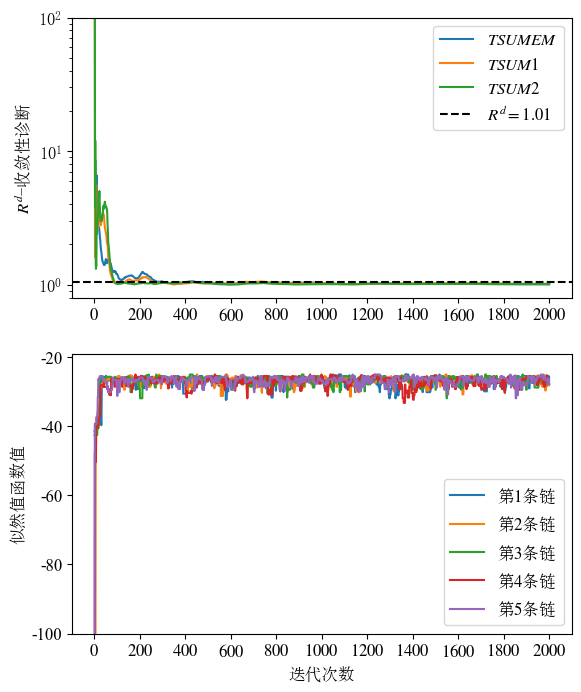

In [19]:
# 画G_R图
import matplotlib.pyplot as plt
import matplotlib
font_options = {'family': 'serif', 'serif': 'Simsun',}
plt.rc('font', **font_options)
matplotlib.rcParams.update({'font.family': 'sans', 'mathtext.fontset': 'stix', 'text.usetex': False})
plt.rcParams['font.sans-serif']=['Simsun'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
font_dict={'family' : 'Times New Roman', 'size'   : 12}
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
x = [(i+1) for i in range(2000)]
x_sticks = np.arange(0, 2001, 200)
plt.xticks(x_sticks)
axes[0].set_yscale("log")
axes[0].set_ylim(0.8, 100)
axes[0].plot(x, GR[:2000, 0], label="$TSUMEM$")
axes[0].plot(x, GR[:2000, 1], label="$TSUM1$")
axes[0].plot(x, GR[:2000, 2], label="$TSUM2$")
axes[0].axhline(y=1.05, color='k', linestyle='--', label="$R^d=1.01$")
axes[0].legend(prop={'family': 'Times New Roman', 'size': 12})
axes[0].set_xticks(x_sticks)
axes[0].set_ylabel("$R^d$-收敛性诊断", size=12, linespacing=1.25)
# 设置x轴刻度 size设置字体大小，fontproperties设置字体样式
xticks = axes[0].get_xticks()
x_label = [f"${i}$" for i in xticks]
axes[0].set_xticks(xticks, x_label, fontproperties = 'Times New Roman', size=12)

# 画logps图
my_y_ticks = np.arange(-100, 1, 10)
axes[1].set_yticks(my_y_ticks)
for i in range(len(logps_l)):
    axes[1].plot(x, logps_l[i][: 2000], label="第$%s$条链" % (i + 1))
axes[1].legend(prop={'family': 'Simsun', 'size': 12})
axes[1].set_ylim((-60, -19))
axes[1].set_xlabel("迭代次数", size=12, linespacing=1.25)
axes[1].set_ylabel("似然值函数值", size=12, linespacing=1.25)
# 设置x轴刻度 size设置字体大小，fontproperties设置字体样式
xticks = axes[1].get_xticks()
x_label = [f"${i}$" for i in xticks]
axes[1].set_xticks(xticks, x_label, fontproperties = 'Times New Roman', size=12)
# 设置y轴刻度的字体和大小
yticks1 = axes[1].get_yticks()
yticks = []
for i in range(len(yticks1)):
    if i % 2 == 0:
        if yticks1[i] < 0:
            yticks.append(yticks1[i])
    else:
        pass
y_label = [f"{i}" for i in yticks]
axes[1].set_yticks(yticks, y_label, fontproperties='Times New Roman', size=12)
# 设置y轴 16单位是像素  相当于word中的小四
# fig.autofmt_xdate()

fig.subplots_adjust(right=0.75)
plt.savefig("./TSUM1/Rd_logps.svg", format="svg", dpi=750, bbox_inches = 'tight')


In [20]:
## 画corner图
logps = np.load(
    "F:\\paper_code\\wofost\\wofost_dreamzs_5chain_logps_chain_0_4000.npy")
parame = np.load(
    "F:\\paper_code\\wofost\\wofost_dreamzs_5chain_sampled_params_chain_0_4000.npy")

column1 = ['logps', 'TSUMEM', "TSUM1", 'TSUM2']
column2 = ["logps", "TSUMEM", "TSUM1", "TSUM2",
           "EFFTB001", "EFFTB002",
           "TMNFTB003", "SLATB001",
           "TDWI", "SPAN", "CVO",
                           "CVL", "FOTB003"]
df = pd.DataFrame(np.concatenate((logps, parame), axis=1), columns=column1)
df_max_logps = df[df['logps'] == df['logps'].max()]
df_max_logps.reset_index(drop=True, inplace=True)


In [21]:
df_max_logps.iloc[13]

logps      -25.057769
TSUMEM      93.199775
TSUM1     1199.214512
TSUM2      794.354507
Name: 13, dtype: float64

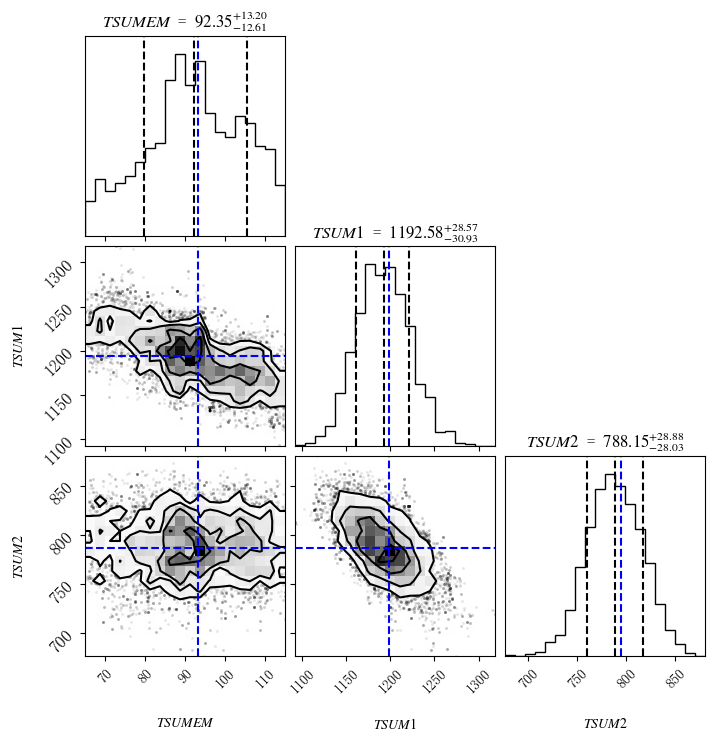

In [22]:
import corner
burnin = 1000
samples = np.concatenate((parame_l[0][burnin:, :], parame_l[1][burnin:, :],
                          parame_l[2][burnin:, :], parame_l[3][burnin:, :], parame_l[4][burnin:, :]))

(_, ndim) = samples.shape

figure = corner.corner(
    samples,
    labels=[
        "$%s$" % str1 for str1 in column1[1:]
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

axes = np.array(figure.axes).reshape((ndim, ndim))

for i in range(ndim):
    for j in range(ndim):
        ax = axes[i, j]
        if j <= i:
            ax.axvline(x=df_max_logps.iloc[13, j + 1],
                       color="b", linestyle="--")
        if j < i:
            # print(df_max_logps.iloc[0, j + 1])
            ax.axhline(y=df_max_logps.iloc[0, i + 1],
                       color="b", linestyle="--")
            

fig.subplots_adjust(right=0.75)
plt.savefig("./TSUM1/corner.svg", format="svg", dpi=750, bbox_inches = 'tight')


## 读取模型参数

In [33]:
tabName = "ZDN180"
year = 2020
nchains = 8
total_iterations = 10000

In [34]:
import pickle
old_samples = list()
for i in range(8):
    path = f"wofost_dreamzs_{nchains}chain_sampled_params_chain_{i}_{total_iterations}_{tabName}.npy"
    old_samples.append(np.load(os.path.join(tabName+str(year), path)))

burnin = 5000

In [35]:
samples = old_samples[0]
for i in range(1, 8):
    samples = np.concatenate((samples, old_samples[i]))


In [36]:
samples = np.concatenate((old_samples[0][burnin:, :], old_samples[1][burnin:, :],
                          old_samples[2][burnin:, :], old_samples[3][burnin:, :], old_samples[4][burnin:, :]))


In [37]:
samples.shape
column = [ "EFFTB003", 
    "TMNFTB003", "SLATB001", 
    "TDWI", "SPAN", "CVO", 
    "CVL", "FLTB003"
        ]
df_sample = pd.DataFrame(samples, columns=column)

In [38]:
df_sample.describe()

,EFFTB003,TMNFTB003,SLATB001,TDWI,SPAN,CVO,CVL,FLTB003
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,1.831741,2.367823,0.072086,1.101730,1.097770,0.612067,1.595749,2.081876
std,0.065059,0.053614,0.003132,0.093793,0.066415,0.040933,0.062231,0.053480
min,1.588749,2.167632,0.062060,0.755564,0.892372,0.446459,1.333280,1.896108
25%,1.787805,2.331858,0.069997,1.037801,1.050055,0.583832,1.553508,2.044285
50%,1.830583,2.366304,0.071987,1.102491,1.101351,0.611000,1.596344,2.082031
75%,1.873795,2.405419,0.074142,1.166825,1.143408,0.639747,1.636931,2.117778
max,2.074835,2.565939,0.083225,1.394026,1.334063,0.774470,1.823425,2.248070


## 读取似然值

In [194]:
parame = np.load(f"{tabName}{year}\wofost_dreamzs_{nchains}chain_sampled_params_chain_5_{total_iterations}_{tabName}.npy")
logps = np.load(f"{tabName}{year}\wofost_dreamzs_{nchains}chain_logps_chain_5_{total_iterations}_{tabName}.npy")

In [195]:
parame.shape

(10000, 8)

In [196]:
column1=['logps', 'TSUMEM', "TSUM1", 'TSUM2']
column2 = ["logps", "EFFTB003",
           "TMNFTB003", "SLATB001",
           "TDWI", "SPAN", "CVO",
                           "CVL", "FLTB003"]
df = pd.DataFrame(np.concatenate((logps, parame), axis=1), columns=column2)
df_max_logps = df[df['logps'] == df['logps'].max()]


In [197]:
df_max_logps

,logps,EFFTB003,TMNFTB003,SLATB001,TDWI,SPAN,CVO,CVL,FLTB003
7729,-195.439508,1.717136,2.236979,0.059897,0.881825,1.048916,1.335318,1.432291,1.847297
7730,-195.439508,1.717136,2.236979,0.059897,0.881825,1.048916,1.335318,1.432291,1.847297
7731,-195.439508,1.717136,2.236979,0.059897,0.881825,1.048916,1.335318,1.432291,1.847297
7732,-195.439508,1.717136,2.236979,0.059897,0.881825,1.048916,1.335318,1.432291,1.847297
7733,-195.439508,1.717136,2.236979,0.059897,0.881825,1.048916,1.335318,1.432291,1.847297
7734,-195.439508,1.717136,2.236979,0.059897,0.881825,1.048916,1.335318,1.432291,1.847297
7735,-195.439508,1.717136,2.236979,0.059897,0.881825,1.048916,1.335318,1.432291,1.847297
7736,-195.439508,1.717136,2.236979,0.059897,0.881825,1.048916,1.335318,1.432291,1.847297
7737,-195.439508,1.717136,2.236979,0.059897,0.881825,1.048916,1.335318,1.432291,1.847297
7738,-195.439508,1.717136,2.236979,0.059897,0.881825,1.048916,1.335318,1.432291,1.847297


In [198]:
with open(F"{tabName}{year}/old_samples_{tabName}.pkl", "rb") as f:
    sample_list = pickle.load(f)
# 计算G_R
GR_list = list()
for i in range(1, len(sample_list[0])):
    sample = [sample_list[0][0:i], sample_list[1][0:i],
              sample_list[2][0:i], sample_list[3][0:i], 
              sample_list[4][0:i], sample_list[5][0:i],
              sample_list[6][0:i], sample_list[7][0:i]]
    GR = Gelman_Rubin(sample)
    GR_list.append(GR)


d:\anaconda3\envs\pcse\lib\site-packages\pydream\convergence.py:18: RuntimeWarning: divide by zero encountered in divide
  Rhat = np.sqrt(np.divide(var_est, W))


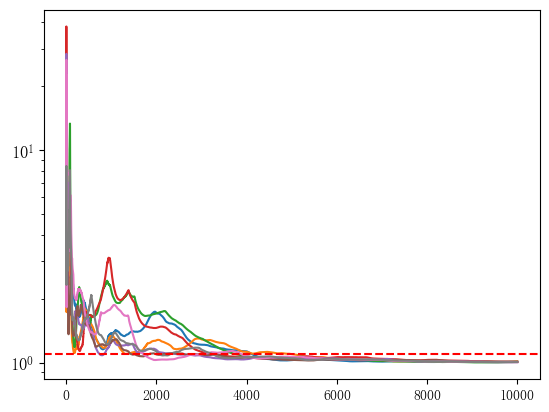

In [199]:
plt.yscale('log')
plt.plot(GR_list)
plt.axhline(y=1.1, color='r', linestyle='--')

## 角点图

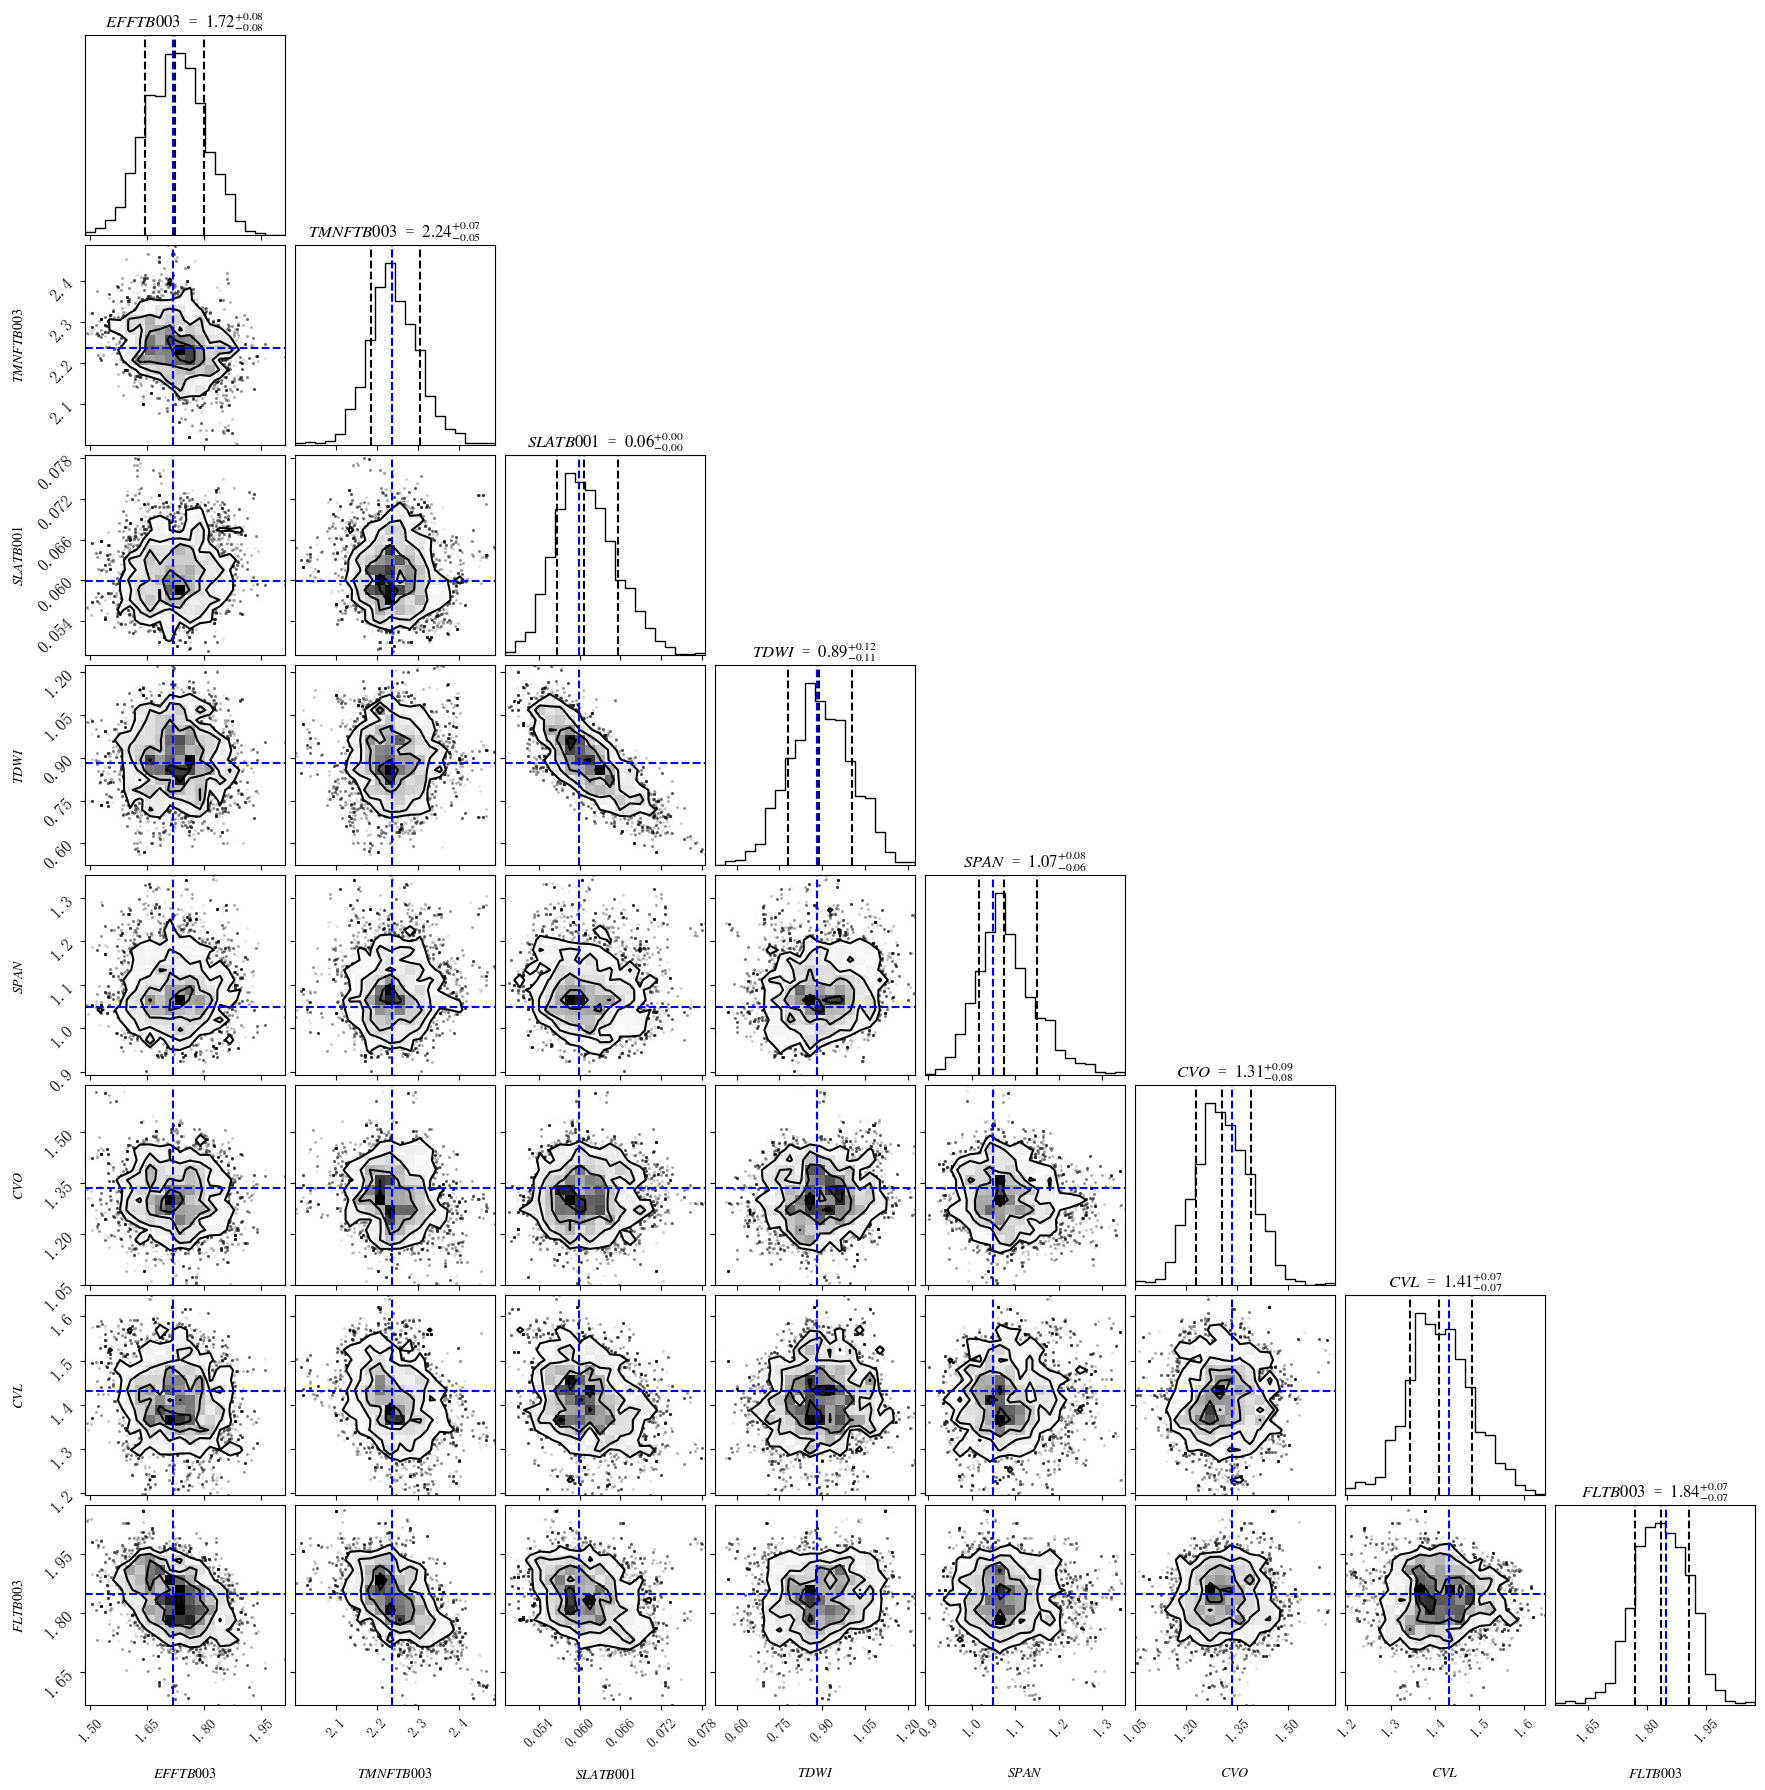

In [200]:
import corner
(_, ndim) = samples.shape

figure = corner.corner(
    samples,
    labels=[
        "$%s$" % str1 for str1 in column2[1: ] 
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

axes = np.array(figure.axes).reshape((ndim, ndim))

for i in range(ndim):
    for j in range(ndim):
        ax = axes[i, j]
        if j <= i:
            ax.axvline(x=df_max_logps.iloc[0, j + 1], color="b", linestyle="--")
        if j < i:
            # print(df_max_logps.iloc[0, j + 1])
            ax.axhline(y=df_max_logps.iloc[0, i + 1], color="b", linestyle="--")
            


In [170]:
old_sample[0][-1]


NameError: name 'old_sample' is not defined

## 画收敛图

In [171]:
GR_list = list()
for i in range(1, len(old_sample[0])):
    sample = [old_sample[0][0:i], old_sample[1][0:i], 
              old_sample[2][0:i], old_sample[3][0:i], old_sample[4][0:i]]
    GR = Gelman_Rubin(sample)
    GR_list.append(GR)



NameError: name 'old_sample' is not defined

In [172]:
df = pd.DataFrame(GR_list, columns=["TSUMEM", "TSUM1", "TSUM2"])



In [173]:
df

,TSUMEM,TSUM1,TSUM2
0,inf,inf,inf
1,inf,inf,inf
2,45.366559,86.863525,103.455618
3,24.507357,11.824185,2.515209
4,26.035818,12.221907,2.776046
...,...,...,...
1994,1.019863,1.007096,1.006572
1995,1.019826,1.007106,1.006568
1996,1.019826,1.007134,1.006584
1997,1.019820,1.007227,1.006565


In [42]:
df.to_csv("./GR.csv")


In [16]:
df = pd.DataFrame(old_sample[0][1000: ], columns=["TSUMEM", "TSUM1", "TSUM2"])


In [17]:
df.describe()

,TSUMEM,TSUM1,TSUM2
count,1000.000000,1000.000000,1000.000000
mean,117.908889,1439.754056,401.710054
std,13.491530,25.616132,0.934020
min,95.004906,1368.902204,400.016478
25%,107.452652,1420.736139,400.990607
50%,118.702290,1441.230401,401.771067
75%,126.382946,1459.466698,402.341506
max,149.404372,1498.313247,403.794065
